## Import Libraries

In [54]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
import pycaret
from pycaret.classification import *
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime

modalities = ['ACC', 'BVP', 'EDA', 'TEMP']

#sampling frequencies
ACC_WE = 32
BVP_WE = 64
EDA_WE = 4
TEMP_WE = 4

ACC_AD = 1920
BVP_AD = 3840
EDA_AD = 240
TEMP_AD = 240

## Auxialiary Functions

In [55]:
def sin_transform(values):
        """
        Applies SIN transform to a series value.
        Args:
            values (pd.Series): A series to apply SIN transform on.
        Returns
            (pd.Series): The transformed series.
        """

        return np.sin(2 * np.pi * values / len(set(values)))

In [56]:
def cos_transform(values):
    """
    Applies COS transform to a series value.
    Args:
        values (pd.Series): A series to apply SIN transform on.
    Returns
        (pd.Series): The transformed series.
    """
    return np.cos(2 * np.pi * values / len(set(values)))

## LIFESNAPS

In [57]:
lifesnaps = pd.read_csv('Final_CSVs/daily_fitbit_sema_df_unprocessed.csv')

In [58]:
lifesnaps

,Unnamed: 0,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,['LIFETIME_DISTANCE'],...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,7405,621e362467b776a2404ad513,2021-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7406,7406,621e36f967b776a240e5e7c9,2021-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7407,7407,621e362467b776a2404ad513,2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7408,7408,621e339967b776a240e502de,2021-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
lifesnaps.columns

Index(['Unnamed: 0', 'id', 'date', 'nightly_temperature', 'nremhr', 'rmssd',
       'spo2', 'full_sleep_breathing_rate', 'daily_temperature_variation',
       'badgeType', 'calories', 'filteredDemographicVO2Max', 'distance',
       'activityType', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration',
       'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake',
       'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio',
       'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label',
       'ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS',
       'TIRED', 'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE

In [60]:
lifesnaps['TENSE/ANXIOUS'].value_counts()

0.0    1786
1.0     504
Name: TENSE/ANXIOUS, dtype: int64

In [61]:
lifesnaps['ALERT'].value_counts()

0.0    1985
1.0     305
Name: ALERT, dtype: int64

In [62]:
lifesnaps["labels"] = np.where(lifesnaps['TENSE/ANXIOUS']== 1, 1, np.where(lifesnaps['ALERT']==1,1, np.where(lifesnaps['SAD']==1,1, 0)))
lifesnaps["labels"].value_counts()

0    6571
1     839
Name: labels, dtype: int64

In [63]:
#Extract features from date
lifesnaps["year"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
lifesnaps["month"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
lifesnaps["weekday"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())
lifesnaps["week"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').isocalendar()[1])
lifesnaps["day"] = lifesnaps["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

In [64]:
# Sin transformation in date features
lifesnaps["month_sin"] = sin_transform(lifesnaps["month"])
lifesnaps["weekday_sin"] = sin_transform(lifesnaps["weekday"])
lifesnaps["week_sin"] = sin_transform(lifesnaps["week"])
lifesnaps["day_sin"] = sin_transform(lifesnaps["day"])

In [65]:
# Cosine transformation in date features
lifesnaps["month_cos"] = cos_transform(lifesnaps["month"])
lifesnaps["weekday_cos"] = cos_transform(lifesnaps["weekday"])
lifesnaps["week_cos"] = cos_transform(lifesnaps["week"])
lifesnaps["day_cos"] = cos_transform(lifesnaps["day"])

In [66]:
lifesnaps = lifesnaps.drop(columns=['Unnamed: 0', 'date', 'ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS','TIRED'])

In [67]:
lifesnaps

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,...,week,day,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos
0,621e2e8e67b776a24055b564,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,...,21,24,1.224647e-16,0.000000,1.224647e-16,-0.988468,-1.000000,1.000000,-1.000000,0.151428
1,621e2e8e67b776a24055b564,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,...,21,25,1.224647e-16,0.781831,1.224647e-16,-0.937752,-1.000000,0.623490,-1.000000,0.347305
2,621e2e8e67b776a24055b564,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,...,21,26,1.224647e-16,0.974928,1.224647e-16,-0.848644,-1.000000,-0.222521,-1.000000,0.528964
3,621e2e8e67b776a24055b564,34.408304,57.493,111.709,NaN,14.8,-2.124199,['LIFETIME_DISTANCE'],2325.10,62.47493,...,21,27,1.224647e-16,0.433884,1.224647e-16,-0.724793,-1.000000,-0.900969,-1.000000,0.688967
4,621e2e8e67b776a24055b564,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,...,21,28,1.224647e-16,-0.433884,1.224647e-16,-0.571268,-1.000000,-0.900969,-1.000000,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,18,1.224647e-16,0.781831,1.490423e-01,-0.485302,-1.000000,0.623490,-0.988831,-0.874347
7406,621e36f967b776a240e5e7c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,20,1.224647e-16,0.433884,1.490423e-01,-0.790776,-1.000000,-0.900969,-0.988831,-0.612106
7407,621e362467b776a2404ad513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,23,1.224647e-16,-0.781831,1.490423e-01,-0.998717,-1.000000,0.623490,-0.988831,-0.050649
7408,621e339967b776a240e502de,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46,19,5.877853e-01,-0.433884,5.633201e-01,-0.651372,0.809017,-0.900969,0.826239,-0.758758


In [68]:
lifesnaps.to_csv('Final_CSVs/lifesnaps_time.csv',index=False)

In [69]:
# added by me
lifesnaps = pd.read_csv('Final_CSVs/lifesnaps_time.csv')

In [70]:
# added by me
from sklearn.impute import SimpleImputer

# Specify the categorical features for imputation
# categorical_features_to_impute = ["LIFETIME_DISTANCE", ...]
categorical_features_to_impute = ["LIFETIME_DISTANCE"]

# Separate numeric and categorical features
numeric_features = lifesnaps.select_dtypes(include='number').columns
categorical_features = lifesnaps.select_dtypes(include='object').columns

# Impute missing values for numeric features
imputer_numeric = SimpleImputer(strategy='mean')
lifesnaps[numeric_features] = imputer_numeric.fit_transform(lifesnaps[numeric_features])

# Impute missing values for categorical features
imputer_categorical = SimpleImputer(strategy='most_frequent')
lifesnaps[categorical_features] = imputer_categorical.fit_transform(lifesnaps[categorical_features])

In [71]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.id.isin(users_train)], data[data.id.isin(users_test)]

In [72]:
train_data, test_data = train_test_split_per_user(lifesnaps)

fold_groups = train_data.id

# Save the 'id' column from the test set
test_ids = test_data['id']

train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [73]:
grid = setup(data=train_data, target='labels', fix_imbalance = True, categorical_features=["badgeType","activityType","age","gender","bmi","step_goal","step_goal_label"], html=False, verbose=False, fold_strategy='groupkfold', fold=3, fold_groups=fold_groups, test_data=test_data) #fix_imbalance = True,


In [74]:
best = compare_models(sort='F1')

Processing:   0%|          | 0/61 [00:00<?, ?it/s]

                                    Model  Accuracy    AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.8635  0.888  0.2867  0.3864   
dummy                    Dummy Classifier    0.8869  0.500  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.3128  0.2422  0.2533    0.7100  
dummy     0.0000  0.0000  0.0000    0.2633  


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3262, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


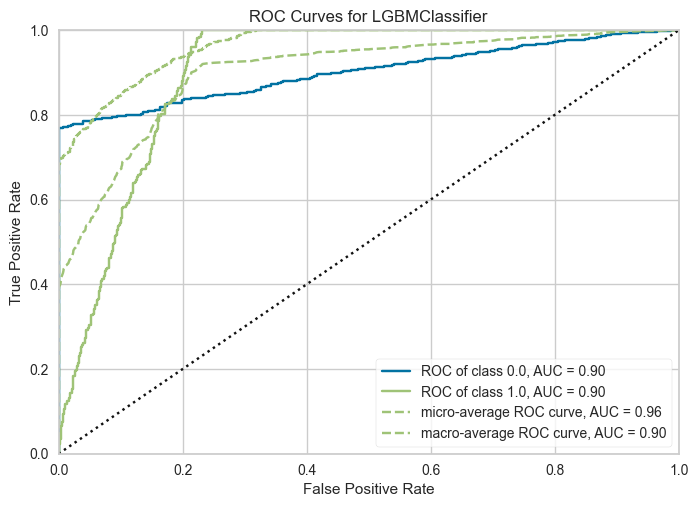

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [75]:
print(best)
plot_model(best)
evaluate_model(best)

In [76]:
predictions = predict_model(best, data=test_data)

                             Model  Accuracy     AUC  Recall  Prec.      F1  \
0  Light Gradient Boosting Machine    0.8741  0.9011  0.3463   0.43  0.3836   

    Kappa     MCC  
0  0.3144  0.3167  


In [77]:
print(predictions.columns)

Index(['nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'daily_temperature_variation', 'badgeType',
       'calories', 'filteredDemographicVO2Max', 'distance', 'activityType',
       'bpm', 'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label',
       'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS',
       'TRANSIT', 'WORK/SCHOOL', 'year', 'month', 'weekday', 'week', 'day',
       'month_s

In [78]:
print(predictions)

      nightly_temperature     nremhr       rmssd       spo2  \
0               34.137688  57.431999   89.602997  95.893227   
1               33.794544  57.681000   94.303001  95.893227   
2               34.611012  57.480999  119.211998  95.893227   
3               34.408302  57.493000  111.709000  95.893227   
4               34.178921  56.750000  103.033997  95.893227   
...                   ...        ...         ...        ...   
2266            33.771648  62.714134   40.021233  95.893227   
2267            33.771648  62.714134   40.021233  95.893227   
2268            33.771648  62.714134   40.021233  95.893227   
2269            33.771648  62.714134   40.021233  95.893227   
2270            33.771648  62.714134   40.021233  95.893227   

      full_sleep_breathing_rate  daily_temperature_variation  \
0                     14.800000                    -1.788325   
1                     15.800000                    -2.462709   
2                     14.600000                    

In [79]:
# Add 'id' column back to predictions DataFrame
predictions['id'] = test_ids  # Use the 'id' column from the test data

In [80]:
print(predictions['id'])

0       621e2e8e67b776a24055b564
1       621e2e8e67b776a24055b564
2       621e2e8e67b776a24055b564
3       621e2e8e67b776a24055b564
4       621e2e8e67b776a24055b564
                  ...           
2266    621e30e267b776a240e5bf90
2267    621e30e267b776a240e5bf90
2268    621e30e267b776a240e5bf90
2269    621e30e267b776a240e5bf90
2270    621e30e267b776a240e5bf90
Name: id, Length: 2271, dtype: object


In [81]:
predictions['labels']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2266    0.0
2267    0.0
2268    0.0
2269    0.0
2270    0.0
Name: labels, Length: 2271, dtype: float32

In [82]:
predictions['bmi']

0        <19
1        <19
2        <19
3        <19
4        <19
        ... 
2266    >=30
2267    >=30
2268    >=30
2269    >=30
2270    >=30
Name: bmi, Length: 2271, dtype: category
Categories (11, object): ['19.0', '20.0', '21.0', '22.0', ..., '29.0', '<19', '>=25', '>=30']

In [83]:
test_data['bmi']

0        <19
1        <19
2        <19
3        <19
4        <19
        ... 
2266    >=30
2267    >=30
2268    >=30
2269    >=30
2270    >=30
Name: bmi, Length: 2271, dtype: object

In [84]:
import os

# Specify folder name
folder_name = "Output_Files"

id = predictions['id']

# Extract true labels (y_true), rename the column
y_true = predictions[['labels']].rename(columns={'labels': 'y_true'})

# Extract predicted labels (y_pred), rename the column
y_pred = predictions[['prediction_label']].rename(columns={'prediction_label': 'y_pred'})

# Identify protected attribute columns
protected_attributes = predictions[['age', 'gender', 'bmi']]

# Concatenate DataFrames containing predictions and protected attributes
all_data = pd.concat([id, y_true, y_pred, protected_attributes], axis=1)

# Create filename
filename = f"LifeSnaps_Generic_Model.csv"

# Create folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Create full path with folder name
filepath = os.path.join(folder_name, filename)

# Save predictions
all_data.to_csv(filepath, index=False)

In [85]:
mismatched_predictions = (all_data['y_pred'] != all_data['y_true']).sum()

print(f"Number of rows with different y_pred and y_true values: {mismatched_predictions}")

Number of rows with different y_pred and y_true values: 286


In [86]:
matched_predictions = (all_data['y_pred'] == all_data['y_true']).sum()

print(f"Number of rows with same y_pred and y_true values: {matched_predictions}")

Number of rows with same y_pred and y_true values: 1985


In [87]:
accuracy = matched_predictions / (matched_predictions+mismatched_predictions)
print(accuracy)

0.8740642888595332


In [88]:
predictions = pd.read_csv('Output_Files/LifeSnaps_Generic_Model.csv')

In [89]:
# bmi encoding
predictions['bmi'] = predictions['bmi'].fillna(predictions['bmi'].mode().iloc[0])
predictions["bmi"] = predictions["bmi"].apply(lambda x: 31.0 if x == '>=30' else x)
predictions["bmi"] = predictions["bmi"].apply(lambda x: 18.0 if x == '<19' else x)
predictions["bmi"] = predictions["bmi"].apply(lambda x: 26.0 if x == '>=25' else x)  # it belongs to overweight
predictions["bmi"] = predictions["bmi"].apply(lambda x: 31 if x == '>=30' else x)

In [90]:
predictions.to_csv('Output_Files/LifeSnaps_Generic_Model.csv', index=False)

In [91]:
predictions = pd.read_csv('Output_Files/LifeSnaps_Generic_Model.csv')

In [92]:
predictions['bmi'] = predictions.bmi.apply(lambda bmi: 0 if bmi < 18.5 else (1 if bmi < 25 else (2 if bmi < 30 else 3)))

In [93]:
predictions.to_csv('Output_Files/LifeSnaps_Generic_Model.csv', index=False)